In [1]:
import torch
import torch.nn as nn
import os
import sys
sys.path.append('/mnt/storage/user/wangxiaodong/DWM_work_dir/lidar_maskgit_debug/src')
from transformers import CLIPTextModel, CLIPTokenizer, CLIPModel, CLIPImageProcessor
from diffuser import StableDiffusionPipeline, AutoencoderKL, DDIMScheduler, UNet2DConditionModel

2024-08-05 09:40:23.592480: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 09:40:23.799481: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 09:40:24.438690: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 09:40:27.291196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/mnt/storage/user/wangxiaodong/DWM_work_dir/lidar_maskgit_debug/src/diffuser/utils/outputs.py:63: UserWarn

In [2]:
# prepare components
device = 'cuda:0'
text_encoder = CLIPTextModel.from_pretrained(
    '/mnt/storage/user/wuzehuan/Downloads/models/stable-diffusion-2-1', subfolder="text_encoder", variant="fp16"
)
vae = AutoencoderKL.from_pretrained(
    '/mnt/storage/user/wuzehuan/Downloads/models/stable-diffusion-2-1', subfolder="vae"
)
clip_model = CLIPModel.from_pretrained(
    "/mnt/storage/user/wangxiaodong/DWM_work_dir/lidar_maskgit_debug/smodels/clip-vit-large-patch14", torch_dtype=torch.float16)

unet = UNet2DConditionModel.from_pretrained(
    "/mnt/storage/user/wangxiaodong/DWM_work_dir/lidar_maskgit_debug/smodels/image-3dboxhdmap-ep100/checkpoint-10000", torch_dtype=torch.float16)

text_encoder.eval()
vae.eval()
clip_model.eval()
text_encoder.to(device)
vae.to(device)
clip_model.to(device)

tokenizer = CLIPTokenizer.from_pretrained('/mnt/storage/user/wuzehuan/Downloads/models/stable-diffusion-2-1', subfolder="tokenizer")
scheduler = DDIMScheduler.from_pretrained('/mnt/storage/user/wuzehuan/Downloads/models/stable-diffusion-2-1', subfolder="scheduler")
feature_extractor = CLIPImageProcessor.from_pretrained('/mnt/storage/user/wuzehuan/Downloads/models/stable-diffusion-2-1', subfolder="feature_extractor")


In [3]:
# prepare pipeline
pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            scheduler=scheduler,
            tokenizer=tokenizer,
            feature_extractor=feature_extractor,
            safety_checker=None
    )
pipeline = pipeline.to(device).to(torch.float16)

You have disabled the safety checker for <class 'diffuser.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [4]:
import timm
layout_encoder = timm.create_model(model_name="convnextv2_base.fcmae", pretrained=True, num_classes=0)
layout_encoder.to(device)
layout_encoder = layout_encoder.half()

In [5]:
# image processer
from torchvision import transforms
from PIL import Image
transform = transforms.Compose([
    transforms.Resize((256, 448)),
    transforms.ToTensor()
])

In [93]:
index = 18843

In [94]:
_3dbox_image_path = f"/mnt/storage/user/wangxiaodong/DWM_work_dir/lidar_maskgit_debug/3dbox_{index}.jpg"
hdmap_image_path = f"/mnt/storage/user/wangxiaodong/DWM_work_dir/lidar_maskgit_debug/hdmap_{index}.jpg"
_3dbox_image = Image.open(_3dbox_image_path)
hdmap_image = Image.open(hdmap_image_path)
_3dbox = transform(_3dbox_image)
hdmap = transform(hdmap_image)
_3dbox = _3dbox.unsqueeze(0).to(device)
hdmap = hdmap.unsqueeze(0).to(device)

In [95]:
weight_dtype = torch.float16
_3dbox_embeddings = layout_encoder\
    .forward_features(_3dbox.to(weight_dtype))\
    .flatten(-2).permute(0, 2, 1)
hdmap_embeddings = layout_encoder\
    .forward_features(hdmap.to(weight_dtype))\
    .flatten(-2).permute(0, 2, 1)
hdmap_embeddings.shape

torch.Size([1, 112, 1024])

In [96]:
# provide prompt_embeds
with open(f"/mnt/storage/user/wangxiaodong/DWM_work_dir/lidar_maskgit_debug/caption_{index}", 'r', encoding='utf-8') as file:
    caption = file.read()
print(caption)
# caption = ""
inputs = tokenizer(
    caption, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
text_input = inputs['input_ids'].to(device)
encoder_hidden_states = text_encoder(text_input)[0]
encoder_hidden_states.shape

a car driving down a street next to a building.


torch.Size([1, 77, 1024])

In [97]:
caption = ""
inputs = tokenizer(
    caption, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
text_input = inputs['input_ids'].to(device)
uncond_encoder_hidden_states = text_encoder(text_input)[0]
uncond_encoder_hidden_states.shape

torch.Size([1, 77, 1024])

In [98]:
# final encoder hidden states
encoder_hidden_states = torch.cat([encoder_hidden_states, _3dbox_embeddings, hdmap_embeddings], dim=1)

In [99]:
uncond_encoder_hidden_states = torch.cat([uncond_encoder_hidden_states, _3dbox_embeddings, hdmap_embeddings], dim=1)

  0%|          | 0/50 [00:00<?, ?it/s]

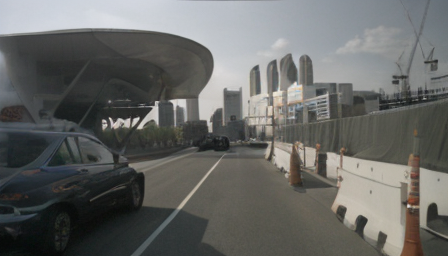

In [112]:
image = pipeline(prompt_embeds=encoder_hidden_states, negative_prompt_embeds=uncond_encoder_hidden_states, guidance_scale=7.5, height=256, width=448).images[0]
image

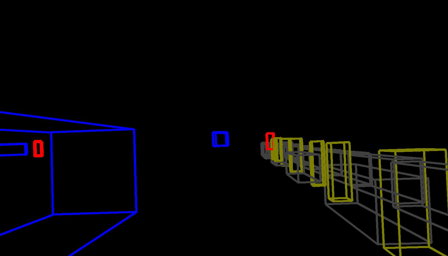

In [101]:
_3dbox_image.resize((448, 256))

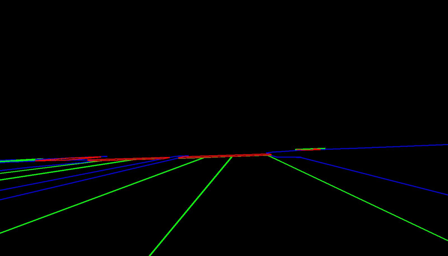

In [102]:
hdmap_image.resize((448, 256))